In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much'])

## Read News Outlets List

In [3]:
news_outlets = pd.read_csv("APRIL2019_DATABASE_State of the Latino News Media - MARCH2019_FINAL_MASTER_DATABASE.csv")
news_outlets.head(3)

,Estado,State,Medio,Media Outlet,Ciudad,City,Dirección,Zip Code,Latitud,Longitud,...,Fuentes de ingresos,Sources of Revenue,Número de empleados/Number of employees,Frecuencia,Frequency,Facebook,Twitter,Instagram,YouTube,Otra red social
0,Alabama,Alabama,Latino News,Latino News,Trussville,Trussville,PO Box 1313,35173,33.637321,-86.560208,...,NaN,NaN,NaN,Semanario,Weekly,https://www.facebook.com/LatinoNewspaper/,https://twitter.com/latinonews1,NaN,NaN,NaN
1,Alabama,Alabama,Alabama TV,Alabama TV,Hoover,Hoover,"2105 Lorna Ridge Lane, Suite 151",35216,33.391113,-86.796007,...,NaN,NaN,NaN,NaN,NaN,https://www.facebook.com/alabamatv/,https://twitter.com/AlabamaTv,https://www.instagram.com/alabamatv/,https://www.youtube.com/channel/UCdXIk0_d5kv_p...,NaN
2,Alabama,Alabama,Líder News,Líder News,Birmingham,Birmingham,PO Box 360535,35236,33.370188,-86.809721,...,Publicidad,Advertising,6-10,Semanal,Weekly,https://www.facebook.com/lidernews.alabama/,NaN,NaN,NaN,NaN


In [4]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

In [5]:
name_fb = news_outlets[['State','Facebook']].copy()
name_fb = name_fb[name_fb['Facebook'].notna()]

In [6]:
name_fb['clean_url'] = name_fb['Facebook'].apply(clean_address)
name_fb.head(3)

,State,Facebook,clean_url
0,Alabama,https://www.facebook.com/LatinoNewspaper/,latinonewspaper
1,Alabama,https://www.facebook.com/alabamatv/,alabamatv
2,Alabama,https://www.facebook.com/lidernews.alabama/,lidernews.alabama


In [7]:
posts1 = pd.read_csv("Media_Outlets1.csv")
posts2 = pd.read_csv("Media_Outlets2.csv")
posts = pd.concat([posts1,posts2],axis=0)
posts

,Page Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,Love,...,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )
0,Univision,univision,259955926518,5924926.0,2020-09-18 09:40:03 EDT,Link,1999,1047,1342,180,...,La popular red social TikTok quedará eliminada...,https://www.univision.com/noticias/tecnologia/...,NaN,NaN,Gobierno de Trump anuncia que bloqueará la des...,El Departamento de Comercio anunció la medida ...,NaN,NaN,"5,888","5,888"
1,Mundo Hispánico,mundohispanico,279933092023507,4576200.0,2020-09-13 13:00:44 EDT,Photo,2163,2849,192,285,...,TODOS CONTRA TRUMP. Con tal de 'sacar' al pres...,https://www.facebook.com/mundohispanico/photos...,https://www.facebook.com/login/?next=https%3A%...,UNITED to 3033 ADEN,NaN,NaN,NaN,NaN,"5,659","5,659"
2,El Nuevo Día,elnuevodia,5996048750,2248500.0,2020-09-30 09:50:41 EDT,Link,1049,1893,582,88,...,Opinión El Nuevo Día | Si es relecto como pres...,https://www.elnuevodia.com/opinion/punto-de-vi...,NaN,NaN,A Joe Biden no le importan los puertorriqueños,NaN,NaN,NaN,"5,638","5,638"
3,Mundo Hispánico,mundohispanico,279933092023507,4568877.0,2020-08-25 12:05:54 EDT,Native Video,2673,216,1630,266,...,"""LO ESTÁ RODEANDO LA MUERTE"". Mhoni Vidente re...",https://www.facebook.com/mundohispanico/videos...,https://www.facebook.com/login/?next=https%3A%...,NaN,"""LO ESTÁ RODEANDO LA MUERTE"". Mhoni Vidente re...",NaN,NaN,NaN,"5,027","5,027"
4,Mundo Hispánico,mundohispanico,279933092023507,4576200.0,2020-09-13 09:03:20 EDT,Photo,1276,1434,458,6,...,"""ESTA ES UNA MALDITA EMERGENCIA"". Gobernador d...",https://www.facebook.com/mundohispanico/photos...,https://www.facebook.com/login/?next=https%3A%...,ΜΗ ÚLTIMA HORA,NaN,NaN,NaN,NaN,"4,905","4,905"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052,NoticiasYa Nuevo México,UnivisionNuevoMexico,261292886579,66932.0,2020-10-03 07:00:11 EDT,Link,0,0,0,0,...,"#LasMásLeídas Una empleada de la Casa Blanca, ...",http://noticiasya.com/2020/10/01/trump-y-melan...,https://noticiasya.com/2020/10/01/trump-y-mela...,NaN,Trump y Melania en cuarentena tras contagio de...,-,NaN,NaN,0,0
4053,NoticiasYa Nuevo México,UnivisionNuevoMexico,261292886579,66932.0,2020-10-02 22:41:02 EDT,Link,0,0,0,0,...,#ÚltimaHora El anuncio de la exconsejera de Tr...,http://noticiasya.com/2020/10/02/quienes-han-s...,https://noticiasya.com/2020/10/02/quienes-han-...,NaN,This is a re-share of a post,NaN,NaN,NaN,0,0
4054,NoticiasYa Nuevo México,UnivisionNuevoMexico,261292886579,66932.0,2020-10-02 22:15:04 EDT,Link,0,0,0,0,...,La profecía del usuario hasta dice cómo sería ...,http://notiya.info/vbrfa,https://noticiasya.com/2020/10/02/tuitero-pred...,NaN,Tuitero predijo que Trump tendría coronavirus ...,Al menos la primera de sus predicciones ya se ...,NaN,NaN,0,0
4055,NoticiasYa Nuevo México,UnivisionNuevoMexico,261292886579,66932.0,2020-10-02 20:30:14 EDT,Link,0,0,0,0,...,La Casa Blanca dice que no habrá una transfere...,https://noticiasya.com/2020/10/02/que-pasara-s...,NaN,NaN,This is a re-share of a post,NaN,NaN,NaN,0,0


In [8]:
posts['URL']

0       https://www.facebook.com/univision/posts/10158...
1       https://www.facebook.com/mundohispanico/posts/...
2       https://www.facebook.com/elnuevodia/posts/1015...
3       https://www.facebook.com/mundohispanico/posts/...
4       https://www.facebook.com/mundohispanico/posts/...
                              ...                        
4052    https://www.facebook.com/UnivisionNuevoMexico/...
4053    https://www.facebook.com/UnivisionNuevoMexico/...
4054    https://www.facebook.com/UnivisionNuevoMexico/...
4055    https://www.facebook.com/UnivisionNuevoMexico/...
4056    https://www.facebook.com/UnivisionNuevoMexico/...
Name: URL, Length: 9949, dtype: object

In [9]:
posts['clean_url'] = posts['URL'].apply(clean_address)
posts['clean_url']

0                  univision
1             mundohispanico
2                 elnuevodia
3             mundohispanico
4             mundohispanico
                ...         
4052    univisionnuevomexico
4053    univisionnuevomexico
4054    univisionnuevomexico
4055    univisionnuevomexico
4056    univisionnuevomexico
Name: clean_url, Length: 9949, dtype: object

In [10]:
posts_st =  posts.merge(name_fb, on="clean_url", how="left")
posts_st.loc[posts_st['Page Name'] == 'El Kentubano','State'] = 'Kentucky'

In [11]:
posts_st['State']

0         California
1            Georgia
2        Puerto Rico
3            Georgia
4            Georgia
            ...     
11703            NaN
11704            NaN
11705            NaN
11706            NaN
11707            NaN
Name: State, Length: 11708, dtype: object

In [12]:
df = posts_st['State'].value_counts().reset_index()
df.columns = ['State','Count']
df

,State,Count
0,Nevada,1061
1,Colorado,807
2,Massachusetts,684
3,Florida,646
4,California,631
5,Georgia,613
6,Arizona,606
7,Puerto Rico,590
8,New York,571
9,Pennsylvania,537


In [13]:
posts.columns

Index(['Page Name', 'User Name', 'Facebook Id', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Total Interactions (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'clean_url'],
      dtype='object')

In [14]:
posts.head(3)

,Page Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,Love,...,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Total Interactions (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x ),clean_url
0,Univision,univision,259955926518,5924926.0,2020-09-18 09:40:03 EDT,Link,1999,1047,1342,180,...,https://www.univision.com/noticias/tecnologia/...,NaN,NaN,Gobierno de Trump anuncia que bloqueará la des...,El Departamento de Comercio anunció la medida ...,NaN,NaN,"5,888","5,888",univision
1,Mundo Hispánico,mundohispanico,279933092023507,4576200.0,2020-09-13 13:00:44 EDT,Photo,2163,2849,192,285,...,https://www.facebook.com/mundohispanico/photos...,https://www.facebook.com/login/?next=https%3A%...,UNITED to 3033 ADEN,NaN,NaN,NaN,NaN,"5,659","5,659",mundohispanico
2,El Nuevo Día,elnuevodia,5996048750,2248500.0,2020-09-30 09:50:41 EDT,Link,1049,1893,582,88,...,https://www.elnuevodia.com/opinion/punto-de-vi...,NaN,NaN,A Joe Biden no le importan los puertorriqueños,NaN,NaN,NaN,"5,638","5,638",elnuevodia


## Filter the most relevant columns

In [15]:
content = posts[['Page Name','Message','Description','Link','Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care','Total Interactions']].copy()
content.shape

(9949, 14)

### Add column to concat Message and Description

In [16]:
concat_message = content['Message'].fillna('') + (' ' + content['Description']).fillna('') + (' ' + content['Link']).fillna('')
content['MessageDescr'] = concat_message

## Tokenize words and Clean-up text

In [17]:
content['cleanMessage'] = content['Message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(9949,)

In [18]:
# Convert to list
data = content.cleanMessage.tolist()

In [19]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [20]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['la', 'popular', 'red', 'social', 'tiktok', 'quedara', 'eliminada', 'de', 'las', 'tiendas', 'de', 'aplicaciones', 'en', 'estados', 'unidos', 'partir', 'de', 'este', 'domingo', 'como', 'parte', 'de', 'la', 'implementacion', 'de', 'una', 'orden', 'ejecutiva', 'del', 'presidente', 'donald', 'trump']]


#### Creating Bigram and Trigram Models

In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['la', 'popular_red_social', 'tiktok', 'quedara', 'eliminada', 'de', 'las', 'tiendas', 'de', 'aplicaciones', 'en', 'estados_unidos', 'partir', 'de', 'este', 'domingo', 'como', 'parte', 'de', 'la', 'implementacion', 'de', 'una', 'orden_ejecutiva', 'del', 'presidente', 'donald', 'trump']


## Remove Stopwords, Make Bigrams and Lemmatize

In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['popular_red', 'social', 'eliminar', 'tienda', 'aplicación', 'unir', 'domingo', 'partir', 'implementacion', 'orden_ejecutiva', 'presidente', 'trump']]


## Bag of Words

In [24]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [25]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [26]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)

In [27]:
final_dict.most_common(1000)

[('donald / trump', 4378),
 ('presidente', 2909),
 ('decir', 1339),
 ('elección', 852),
 ('coronavirus', 837),
 ('debatir', 834),
 ('candidato', 698),
 ('presidencial', 611),
 ('hacer', 498),
 ('ano', 475),
 ('estadounidense', 449),
 ('democrata', 428),
 ('republicano', 421),
 ('dar', 408),
 ('anunciar', 406),
 ('personar', 389),
 ('detalle', 374),
 ('votar', 373),
 ('nuevo', 359),
 ('hoy', 350),
 ('noviembre', 345),
 ('campana', 326),
 ('partir', 317),
 ('casa_blanca', 316),
 ('despues', 313),
 ('\ufeff1', 297),
 ('noticiar', 294),
 ('millón', 293),
 ('semana', 293),
 ('destinar', 289),
 ('unir', 273),
 ('discursar', 273),
 ('ahora', 272),
 ('contar', 269),
 ('mandatario', 268),
 ('pasar', 266),
 ('apoyar', 253),
 ('tambien', 245),
 ('primero', 241),
 ('inmigrante', 235),
 ('poder', 235),
 ('pandemia', 228),
 ('evento', 226),
 ('solo', 224),
 ('viernes', 223),
 ('noche', 218),
 ('electoral', 217),
 ('ultimar', 215),
 ('llegar', 213),
 ('ser', 213),
 ('mirar', 210),
 ('jueves', 205),
 

In [28]:
docs = ([' '.join(ele) for ele in data_words_nostops] )

In [29]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape

(9949, 16751)

In [30]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [31]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,1.631565
presidente,2.325280
donald,2.689439
biden,2.882817
joe,3.401823
...,...
paramilitar,9.512181
paralizo,9.512181
paralizaran,9.512181
parks,9.512181


In [32]:
# count matrix 


#count_vector=cv.transform(docs['cleanMessage']) 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [33]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [34]:
df

,tfidf
aplicaciones,0.279503
domingo,0.198744
donald,0.102763
ejecutiva,0.240466
eliminada,0.347966
implementacion,0.328448
orden,0.196022
parte,0.189860
partir,0.222988
popular,0.239709


In [35]:
word = df.index[0]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,#últimahora a partir del domingo no se podrán ...,4
1,el departamento de comerció indica que cualqui...,1
2,a partir de este domingo 20 de septiembre no s...,1
3,el gobierno del presidente donald trump dispus...,1
4,una jueza de california bloqueó este domingo l...,1
5,#últimahora un juez de ee. uu. bloqueó tempora...,1
6,inmigración gobierno no admitirá nuevos solici...,1
7,ee.uu. prohíbe ‘tiktok’ y ‘wechat’ desde el 20...,1
8,📌 una corte de washington d.c. ordenó al gobie...,1
9,"el 18 de septiembre, el gobierno del president...",1


### Repeated messages

In [36]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

results.to_csv("mostpopularNewsMedia.csv")

In [37]:
results.sort_values(by='Total Interactions',ascending=False)

,Counts,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions
MessageDescr,,,,,,,,,,,
No olviden poner en sus oraciones de este día al presidente de esta bella nación Donald Trump y a su familia. El mandatario resultó positivo al COVID-19 al igual que su esposa. También por las demás personas en el mundo que sufren de este mal. Que Dios les permita salir de esta dura prueba pronto. Detalles: https://bit.ly/2GngCAF:=:https://mundohispanico.com/trump-da-positivo-al-coronavirus-melania-tambien/ https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3447210165346413/?type=3,1,7281,9258,1668,373,746,3875,1247,160,194,24802
PAGARÁN CARO quienes ‘se atrevan’ a publicar mensajes deseándole la MUERTE a TRUMP: https://bit.ly/2Slf5xB:=:https://mundohispanico.com/twitter-muerte-trump-eliminaran-mensajes-y-cuentas/ https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3450426435024786/?type=3,1,3806,7449,904,171,848,3742,209,71,58,17258
"¡ES EN SERIO! Presentan ley que busca DESTITUIR al PRESIDENTE, y Trump estalla contra ""LA LOCA"" que tuvo la idea: https://bit.ly/36Qidua:=:https://mundohispanico.com/propuesta-para-destituir-al-presidente/ https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3470158103051619/?type=3",1,2345,5013,484,137,344,1151,20,142,6,9642
ÚLTIMA HORA: Doctor de Trump hace inesperado anuncio sobre la salud del presidente 👉🏻 https://bit.ly/3jPymUf:=:https://mundohispanico.com/trump-sin-riesgo-contagio/ https://www.facebook.com/MarioGuevaraNews/photos/a.626937290707062/3474044079329688/?type=3,1,1814,5266,408,143,109,605,17,451,18,8831
"La popular red social TikTok quedará eliminada de las tiendas de aplicaciones en Estados Unidos a partir de este domingo, como parte de la implementación de una orden ejecutiva del presidente Donald Trump. El Departamento de Comercio anunció la medida en un comunicado, alegando amenazas a la seguridad nacional y como implementación de una orden ejecutiva del presidente Trump. https://www.univision.com/noticias/tecnologia/gobierno-de-trump-anuncia-que-bloqueara-la-descarga-de-tiktok-y-wechat-a-partir-del-domingo?utm_campaign=Univision&utm_medium=social&utm_source=facebook",1,1999,1047,1342,180,584,573,51,97,15,5888
...,...,...,...,...,...,...,...,...,...,...,...
"With medical experts saying the president could still be contagious and the White House refusing to say when Trump last tested negative, Trump is planning a 'Law and Order' event on Saturday with hundreds in attendance. Dr. Kavita Patel reacts. http://a.msn.com/01/en-us/BB19SQvP?ocid=sf2",1,0,0,0,0,0,0,0,0,0,0
"While Trump said publicly it would “just disappear,” he told journalist Bob Woodward that he knew coronavirus was “deadly stuff.” https://www.huffpost.com/entry/trump-coronavirus-bob-woodward_n_5f58fd32c5b6b48507fabc99?ncid=engmodushpmg00000003",1,0,0,0,0,0,0,0,0,0,0
What was supposed to be the first in a series of policy discussions leading up to the election quickly devolved into a shouting match. https://www.al.com/politics/2020/09/constant-interruptions-insults-obscure-substantive-discussion-at-first-presidential-debate-in-cleveland.html,1,0,0,0,0,0,0,0,0,0,0


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [38]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


[[('aplicación', 1),
  ('domingo', 1),
  ('eliminar', 1),
  ('implementacion', 1),
  ('orden_ejecutiva', 1),
  ('partir', 1),
  ('popular_red', 1),
  ('presidente', 1),
  ('social', 1),
  ('tienda', 1),
  ('trump', 1),
  ('unir', 1)]]

## Building the Topic Model

In [39]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [40]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.177*"octubre" + 0.124*"primero" + 0.101*"noviembre" + 0.099*"republicano" '
  '+ 0.094*"noticiar" + 0.074*"esperar" + 0.061*"conocer" + 0.057*"dejar" + '
  '0.037*"experto" + 0.012*"familiar"'),
 (1,
  '0.303*"presidencial" + 0.186*"personar" + 0.185*"casa_blanca" + '
  '0.059*"participar" + 0.036*"septiembre" + 0.020*"policia" + 0.013*"condado" '
  '+ 0.013*"caravana" + 0.012*"politico" + 0.008*"mitin"'),
 (2,
  '0.110*"encontrar" + 0.092*"poner" + 0.081*"general" + 0.072*"virtual" + '
  '0.071*"trabajar" + 0.070*"llevar" + 0.057*"mayor" + 0.056*"indocumentado" + '
  '0.035*"riesgo" + 0.033*"interrupción"'),
 (3,
  '0.171*"mandatario" + 0.117*"vivir" + 0.111*"unir" + 0.075*"acordar" + '
  '0.063*"considerar" + 0.052*"actual" + 0.049*"estudiar" + 0.040*"telemundo" '
  '+ 0.029*"nivel" + 0.026*"proponer"'),
 (4,
  '0.139*"viernes" + 0.089*"encuestar" + 0.084*"noche" + 0.076*"temer" + '
  '0.066*"segun" + 0.054*"resultar" + 0.042*"muerte" + 0.038*"frente" + '
  '0.037*"federal"

## Compute Model Perplexity and Coherence Score


In [41]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.370100179193713

Coherence Score:  0.36977970447255315


## Visualize the topics-keywords

In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.376958 -0.253998       1        1  17.927374
16     0.206084  0.371447       2        1  11.568320
7      0.072424  0.029854       3        1   7.508050
0      0.026822  0.007028       4        1   5.912612
4      0.010566  0.000895       5        1   5.501061
11    -0.011740 -0.005558       6        1   5.336385
1      0.041202  0.013053       7        1   5.206854
5      0.055420  0.020092       8        1   5.017157
17     0.016776  0.003512       9        1   4.605615
13    -0.042448 -0.012769      10        1   4.431455
12    -0.021852 -0.007902      11        1   4.018316
14    -0.048189 -0.013791      12        1   3.647388
3     -0.057977 -0.015578      13        1   3.646206
2     -0.038930 -0.012094      14        1   3.616840
8     -0.065463 -0.016789      15        1   2.835029
19    -0.086648 -0.019771      16        1   2.733028
18    -0.099570 -0.021207      17        1   2.112254
15    -0.106379 -0.021820      18        1   1.852509
6     -0.112843 -0.022262      19        1   1.624098
9     -0.114215 -0.022339      20        1   0.899448, topic_info=             Term          Freq         Total Category  logprob  loglift
10          trump  10134.000000  10134.000000  Default  30.0000  30.0000
7      presidente   6658.000000   6658.000000  Default  29.0000  29.0000
138         decir   3338.000000   3338.000000  Default  28.0000  28.0000
86        debatir   2655.000000   2655.000000  Default  27.0000  27.0000
137   coronavirus   2385.000000   2385.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
601       votante      0.045082      1.860461  Topic20  -9.8459   0.9910
888           hoy      0.045082      1.861129  Topic20  -9.8459   0.9907
1232     publicar      0.045080      1.860298  Topic20  -9.8460   0.9911
454        latino      0.045079      1.860019  Topic20  -9.8460   0.9912
699           ser      0.045079      1.860521  Topic20  -9.8460   0.9910

[878 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
335      10  0.990503    abogar
228      12  0.970432     abrir
92       12  0.877971  accionar
290      13  0.992866   acordar
317      14  0.878050     actor
...     ...       ...       ...
321      14  0.993708   virtual
343      10  0.995265   visitar
180      13  0.996062     vivir
34       17  0.996497     votar
135       8  0.996189        ﻿1

[290 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 17, 8, 1, 5, 12, 2, 6, 18, 14, 13, 15, 4, 3, 9, 20, 19, 16, 7, 10])

## Building LDA Mallet Model

In [43]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [44]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('trump', 0.0931899641577061),
   ('detalle', 0.08288530465949821),
   ('contar', 0.056899641577060935),
   ('visitar', 0.04256272401433692),
   ('presidente', 0.031137992831541218),
   ('estadounidense', 0.023521505376344086),
   ('mandatario', 0.019265232974910396),
   ('ser', 0.018369175627240143),
   ('gobernador', 0.016129032258064516),
   ('llamar', 0.015456989247311828)]),
 (17,
  [('trump', 0.06947324761509747),
   ('ano', 0.05744504355039403),
   ('pagar', 0.03691414350891746),
   ('medir', 0.03484031522189963),
   ('impuesto', 0.03380340107839071),
   ('dolar', 0.032766486934881794),
   ('millón', 0.026337619245126502),
   ('solo', 0.025715470759021152),
   ('declaración', 0.01845707175445873),
   ('ultimos', 0.01845707175445873)]),
 (11,
  [('hoy', 0.06167690956979807),
   ('noticiar', 0.035776997366110626),
   ('ciudad', 0.024143985952589993),
   ('domingo', 0.023485513608428446),
   ('septiembre', 0.023485513608428446),
   ('hijo', 0.021729587357330993),
   ('poli

## Finding the optimal number of topics for LDA

In [45]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [46]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

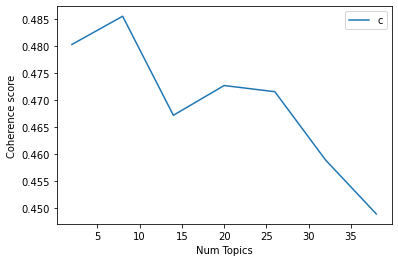

In [47]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4803
Num Topics = 8  has Coherence Value of 0.4856
Num Topics = 14  has Coherence Value of 0.4672
Num Topics = 20  has Coherence Value of 0.4727
Num Topics = 26  has Coherence Value of 0.4716
Num Topics = 32  has Coherence Value of 0.459
Num Topics = 38  has Coherence Value of 0.449


In [49]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.072*"elección" + 0.070*"debatir" + 0.059*"candidato" + '
  '0.049*"presidencial" + 0.035*"democrata" + 0.031*"votar" + '
  '0.029*"noviembre" + 0.025*"\ufeff1" + 0.023*"campana" + 0.018*"electoral"'),
 (1,
  '0.052*"decir" + 0.024*"noticiar" + 0.020*"poder" + 0.019*"unir" + '
  '0.014*"ahora" + 0.014*"juez" + 0.013*"acordar" + 0.013*"personar" + '
  '0.013*"mujer" + 0.012*"ano"'),
 (2,
  '0.068*"coronavirus" + 0.028*"estadounidense" + 0.028*"dar" + 0.027*"trump" '
  '+ 0.025*"presidente" + 0.018*"anunciar" + 0.018*"mandatario" + 0.017*"ser" '
  '+ 0.017*"despues" + 0.016*"pandemia"'),
 (3,
  '0.114*"trump" + 0.032*"hoy" + 0.030*"presidente" + 0.027*"destinar" + '
  '0.025*"discursar" + 0.022*"primero" + 0.021*"hacer" + 0.019*"mirar" + '
  '0.017*"visitar" + 0.017*"vez"'),
 (4,
  '0.027*"partir" + 0.021*"nuevo" + 0.017*"inmigrante" + 0.013*"ciudad" + '
  '0.013*"ayudar" + 0.011*"federal" + 0.011*"domingo" + 0.011*"protestar" + '
  '0.010*"octubre" + 0.010*"grupo"'),
 (5,
  '0.

##  Finding the dominant topic in each sentence

In [50]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1617,"millón, ano, personar, pagar, impuesto, menos,...",La popular red social TikTok quedará eliminada...
1,1,4.0,0.1500,"partir, nuevo, inmigrante, ciudad, ayudar, fed...",TODOS CONTRA TRUMP. Con tal de sacar al presid...
2,2,1.0,0.1422,"decir, noticiar, poder, unir, ahora, juez, aco...",Opinión El Nuevo Día | Si es relecto como pres...
3,3,6.0,0.1783,"trump, presidente, republicano, detalle, conta...","""LO ESTÁ RODEANDO LA MUERTE"". Mhoni Vidente re..."
4,4,6.0,0.1379,"trump, presidente, republicano, detalle, conta...","""ESTA ES UNA MALDITA EMERGENCIA"". Gobernador d..."
5,5,0.0,0.1250,"elección, debatir, candidato, presidencial, de...",nan
6,6,0.0,0.1682,"elección, debatir, candidato, presidencial, de...",El astro boricua exhorta a votar por el candid...
7,7,7.0,0.1626,"presidente, trump, decir, casa_blanca, evento,...","Simpatizantes de Trump asistieron al evento ""L..."
8,8,5.0,0.1662,"millón, ano, personar, pagar, impuesto, menos,...",La decisión 2-1 pone en riesgo de deportación ...
9,9,4.0,0.1500,"partir, nuevo, inmigrante, ciudad, ayudar, fed...",TODOS CONTRA TRUMP. Con tal de sacar al presid...


## Find the most representative document for each topic

In [51]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
#pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4413,"elección, debatir, candidato, presidencial, de...",La ventaja de Biden sobre Trump se amplió tras...
1,1.0,0.4617,"decir, noticiar, poder, unir, ahora, juez, aco...",𝐌á𝐬 𝐝𝐞 𝟓𝟒𝟎 𝐧𝐢ñ𝐨𝐬 𝐢𝐧𝐦𝐢𝐠𝐫𝐚𝐧𝐭𝐞𝐬 𝐬𝐢𝐠𝐮𝐞𝐧 𝐬𝐞𝐩𝐚𝐫𝐚𝐝𝐨𝐬 ...
2,2.0,0.7174,"coronavirus, estadounidense, dar, trump, presi...",TRUMP Y MELANIA DAN POSITIVO AL CORONAVIRUS Tr...
3,3.0,0.3237,"trump, hoy, presidente, destinar, discursar, p...","""Este comportamiento que está a la luz ahora q..."
4,4.0,0.5449,"partir, nuevo, inmigrante, ciudad, ayudar, fed...",INMIGRACIÓN Washington Post: ICE hará redadas ...


In [52]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,5.0,"millón, ano, personar, pagar, impuesto, menos, dolar, solo, septiembre, semana",2217.0,0.2228
1.0,4.0,"partir, nuevo, inmigrante, ciudad, ayudar, federal, domingo, protestar, octubre, grupo",1207.0,0.1213
2.0,1.0,"decir, noticiar, poder, unir, ahora, juez, acordar, personar, mujer, ano",1044.0,0.1049
3.0,6.0,"trump, presidente, republicano, detalle, contar, noche, apoyar, democratas, criticar, segundar",1165.0,0.1171
4.0,6.0,"trump, presidente, republicano, detalle, contar, noche, apoyar, democratas, criticar, segundar",1144.0,0.1150
5.0,0.0,"elección, debatir, candidato, presidencial, democrata, votar, noviembre, ﻿1, campana, electoral",898.0,0.0903
6.0,0.0,"elección, debatir, candidato, presidencial, democrata, votar, noviembre, ﻿1, campana, electoral",1167.0,0.1173
7.0,7.0,"presidente, trump, decir, casa_blanca, evento, salud, semana, hora, lunes, pasar",1107.0,0.1113
